## SOM_BIs_comp.ipynb

This notebooked identifies the optimum set of node clusters to define the SOM blocking index from the SOM dataset of best matching units (SOM_data) and the ground truth dataset (GTD)



In [20]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import math
import sys
import pandas as pd
import os
import matplotlib as mpl
import matplotlib
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
import cartopy
import xarray as xr
import glob
from itertools import groupby
from scipy import stats
import cartopy.crs as ccrs
import statsmodels.stats.multitest as multipletests
import itertools

In [33]:
#define strings for the input GTD and SOM data
SOM_data_str = "C:/Users/carlt/Documents/PhD/Data/reanal/SOM/SOM_data_occ_JJA_extd_era5_z_LTDM_timedtrnd_1979-2019_JJAextd.nc"
GTD_str = "C:/Users/carlt/Documents/PhD/Data/GTD/GTD_1979-2019_JJAextd.nc"

#define string for output figures
fig_str_SOM_GTD_hist = f"C:/Users/carlt/Documents/PhD/plots/SOM_BI_comp/z_GTD_blo_comp_hist_9nodes.pdf"
fig_str_SOM_BI_skill = f"C:/Users/carlt/Documents/PhD/Plots/SOM_BI_comp/z_F1_9nodes_prec_clus_comb_corr.pdf"

fig_str_SOM_BI_comb = f"C:/Users/carlt/Documents/PhD/Plots/SOM_BI_comp/z_F1_9nodes_hist_comp"

#define other variables
seas = "JJA" # season
var_str = "z500" # string to define variable in caption for histogram figure
rowcol = 3 # the number of rows/columns - NB need to change to investigate non-square node topologies
skill_str = "precision" # skill metric to order the clusters by

#load the data
GTD = xr.open_dataset(GTD_str)['blocking']
SOM_data = xr.open_dataset(SOM_data_str)['SOM_data']


In [34]:

def create_nodes_arr_sq(rowcol):
    """
    Create the arrangement of nodes to label the set
    assumes a square arrangement of nodes
    """
    arr = np.ones((rowcol, rowcol))
    for i in range(rowcol):
        arr[i] = arr[i]*range(1+rowcol*i,rowcol+1+rowcol*i)
    return arr



In [92]:

def plot_SOM_BI_performance(rowcol, SOM_data, skill_str, fig_str_SOM_BI_skill, fig_str_SOM_GTD_hist, fig_str_SOM_BI_comb, GTD, var_str, seas,
                           clus_num_arr, prec_arr, recall_arr, F1_arr):
    """
    Create plots to show the SOM-BI performance
    rowcol - the number of rows and columns in the data (will need to change when using non-square node topologies)
    """
    #skill score to order the clusters by
    skill_str = "precision"

    nodes_arr = create_nodes_arr_sq(rowcol)
    nodes = np.prod(nodes_arr.shape)
    #need to identify some way of amtching the two datasets
    #identify the number assigned to the node
    SOM_data_node_list = [(SOM_data[:,:,i]*nodes_arr).sum(axis=0).sum(axis=0) for i in range(SOM_data.shape[2])]
    SOM_nodenum = xr.concat(SOM_data_node_list, dim = "node_num")
    SOM_nodenum_seas = SOM_nodenum.isel(node_num = np.isin(GTD['time.season'], seas))
    GTD_seas = GTD.sel(time = np.isin(GTD['time.season'], seas))
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
    #plot the histograms of blocked and non-blocked days
    plot_hist_blo(GTD_seas, SOM_nodenum_seas, fig_str_SOM_GTD_hist, nodes, ax1) #, caption=f"based on GTD and {var_str} SOMs")

    ds_arr = []
    #implement the persistence within the blocking criterea by studying every five day period
    blocked_days, SOM_nodes = GTD.values, SOM_nodenum.values
    persis_thresh = 5
    persis_block = []
    SOM_cluster = []
    for i in range(len(blocked_days)-persis_thresh):
        if sum(blocked_days[i:i+persis_thresh]) == persis_thresh:
            persis_block.append(1)
        else:
            persis_block.append(0)
        SOM_cluster.append(str(np.unique(SOM_nodes[i:i+persis_thresh])))

    SOM_clusters_block, SOM_clusters_block_occ = np.unique([clus for i, clus in enumerate(SOM_cluster) if (persis_block[i] == 1)], return_counts=True)
    SOM_clusters_noblock, SOM_clusters_noblock_occ = np.unique([clus for i, clus in enumerate(SOM_cluster) if (persis_block[i] == 0)], return_counts=True)
    
    #print("Calculating skill of individual clusters")
    #blocks_one_clusnum = calc_skill_clusters(blocked_days, GTD_seas, persis_thresh, SOM_nodes, SOM_clusters_block, seas)
    
    #print("Calculating skill of combined clusters")
    #clus_num_arr, prec_arr, recall_arr, F1_arr = calc_skill_cluster_sets(blocked_days, GTD_seas, persis_thresh, SOM_nodes, blocks_one_clusnum, skill_str, seas)
    plot_SOM_BI_skill(clus_num_arr, prec_arr, recall_arr, F1_arr, fig_str_SOM_BI_skill, ax2)
    fig.savefig(f"{fig_str_SOM_BI_comb}.pdf", bbox_inches="tight", dpi = 300)
    fig.savefig(f"{fig_str_SOM_BI_comb}.png", bbox_inches="tight", dpi = 300)    
    return 0#return SOM_clusters_block, blocked_days, persis_thresh, SOM_nodes, clus_num_arr, prec_arr, recall_arr, F1_arr
    



In [185]:


def plot_hist_blo(blocking_occ, SOM_nodenum, savefig_str, num_nodes, ax, caption=0):
    """
    Plot the histograms of blocking for the GTD and not
    """
    alpha_val = 1
    nodes_notblo = SOM_nodenum.values*(blocking_occ==0).values
    nodes_blo = SOM_nodenum.values*blocking_occ.values
    freq_blo, freq_notblo = int(float((blocking_occ==1).mean())*1000)/10, int(float((blocking_occ==0).mean()*1000))/10
    nodes_blo_rem, nodes_notblo_rem = nodes_blo[nodes_blo != 0], nodes_notblo[nodes_notblo != 0]

    #hatch="/", lw=1.,
    ax.hist((nodes_notblo_rem,nodes_blo_rem), bins = np.arange(0.5,num_nodes+1.5,1), density = True, alpha = alpha_val, label = (f"not blocked ({freq_notblo}% of days)",f"blocked ({freq_blo}% of days)"), ec = "k",
            lw=3) 
    
    ax.text(0.017,0.97, '(b)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
           bbox={'facecolor':'white', 'alpha':1, 'pad':5, 'linewidth':2, 'edgecolor':'b'},
        fontsize=15)
#     for i, txt in enumerate(["(a)", "1", "2", "3", "4", "5", "6", "7", "8", "9"]):
#         ax.text(1.1+i*0.2,0.965, txt,
#             horizontalalignment='left',
#             verticalalignment='top',
#             transform=ax.transAxes,
#                bbox={'facecolor':'white', 'alpha':1, 'pad':5, 'linewidth':2, 'edgecolor':'b'},
#             fontsize=15)   
    #ax.hist(nodes_blo_rem, bins = np.arange(0.5,num_nodes+1.5,1), density = True, alpha = alpha_val, label = f"blocked ({freq_blo}% of days)", ec = "k", hatch="//", lw=3) 

    if caption != 0:
        ax.set_xlabel(f"SOM node number \n \n {caption}")
    else:
        ax.set_xlabel(f"SOM node number")
    ax.set_ylabel("Percentage occurrence")
    ax.set_xticks(np.arange(1,num_nodes+1,1))
    ax.set_yticklabels(np.arange(0,35,5))    
    ax.legend()

    #fig.savefig(savefig_str, bbox_inches="tight", dpi = 300)


In [186]:
def plot_SOM_BI_skill(clus_num_arr, prec_arr, recall_arr, F1_arr, fig_str, ax):
    """
    Create the plots showing the skill score of the blocking patterns
    """
    #fig = plt.figure()
    alpha_val = 0.7
    #plt.title(f"Skill score of different sets of node clusters \n for {nodes} nodes {var_str} vs GTD")
    ax.scatter(clus_num_arr, prec_arr, label = "P", marker = "^", alpha = alpha_val, color = "r")
    ax.scatter(clus_num_arr, recall_arr, label = "R", marker = "v", alpha = alpha_val, color = "g")
    ax.scatter(clus_num_arr, F1_arr, label = "F1", marker = "x", alpha = alpha_val, color = "b")
    ax.legend(loc="lower right")#bbox_to_anchor=(1,1))
    ax.set_xlabel("Number of node groups selected")# \n node clusters are added to the set, starting with the nodes that \n have the highest precision")
    ax.set_ylabel("Skill score")
    # build a rectangle in axes coords
    ax.text(0.017,0.97, '(c)',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
           bbox={'facecolor':'white', 'alpha':1, 'pad':5, 'linewidth':2, 'edgecolor':'b'},
        fontsize=15)
    ax.set_xlim(-1,52)
    #print(f"peak F1 score = {max(F1_arr)}")
    peak_F1_idx = np.where(np.array(F1_arr) == max(F1_arr))[0][0]
    #print(f"prec for peak F1 score = {prec_arr[peak_F1_idx]}")
    #print(f"recall for peak F1 score = {recall_arr[peak_F1_idx]}")    
    #print(f"number of node groups for peak F1 score = {clus_num_arr[peak_F1_idx]}") 
    

0

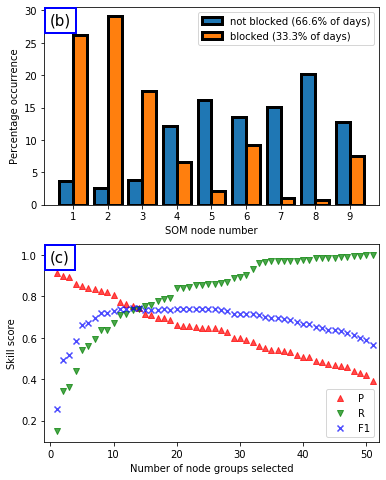

In [187]:
plot_SOM_BI_performance(rowcol, SOM_data, skill_str, fig_str_SOM_BI_skill, fig_str_SOM_GTD_hist, fig_str_SOM_BI_comb, GTD, var_str, seas, clus_num_arr, prec_arr, recall_arr, F1_arr)

In [94]:
def calc_skill_clusters(blocked_days, GTD_seas, persis_thresh, SOM_nodes, SOM_clusters_block, seas):
    """
    Calculates the individual skill score of each cluster
    takes several seconds because ofthe creation of the blocked clusters
    """
    ds_arr_ones = []
    for clus in SOM_clusters_block:
        print(f"clus = {clus}")
        node_cluster_set_test = [clus]
        node_cluster_set_test_str = [str(clus).replace(',', '') for clus in node_cluster_set_test]
        #calculate the blocked days which the new cluster determines
        blocked_days_clus = calc_blocked_days_clus(blocked_days, persis_thresh, SOM_nodes, node_cluster_set_test_str)
        #define as DataArray and select JJA to remove the extended days included for classifying blocks
        blocked_days_clus_xr = xr.DataArray(blocked_days_clus, name = "blocking", dims={"time": GTD['time']})
        blocked_days_clus_xr['time'] = GTD['time']
        blocked_days_clus_seas = blocked_days_clus_xr.sel(time=np.isin(blocked_days_clus_xr['time.season'], seas))
        prec, recall, F1 = calc_pr_rc_F1(GTD_seas, blocked_days_clus_seas)
        print(f"prec, recall, F1 = {prec}, {recall}, {F1}")
        #calculate precision, recall and F1
        if len(str(node_cluster_set_test)) == 1:
            comb_str = f"{node_cluster_set_test[0]}".replace("'", "")
        else:
            comb_str = f"{str(node_cluster_set_test)[1:-1]}".replace("'", "")        
        ds=xr.Dataset({'precision': prec, 'recall': recall, 'F1': F1, 'clus_num': int(len(node_cluster_set_test)), 'set': str(comb_str)})
        ds_arr_ones.append(ds)
    blocks_one_clusnum = xr.concat(ds_arr_ones, dim = "set")
    return blocks_one_clusnum
    

In [95]:

def calc_blocked_days_clus(blocked_days, persis_thresh, SOM_nodes, node_cluster_set_test_str):
    """
    Calculate the number of blocked days in the cluster
    NB this function is fairly slow - perhaps a list comprehension could speed it up?
    SOM_nodes - list of labelled SOM nodes for each day [1,2,9...,7,6]
    blocked_days - arrangement of blocked days in the GTD
    persis_thresh - threshold for number of days to limit blocking
    node_cluster_set_test_str - the set of node clusters being tested, stored as a list of strings ['[1, 2, 5]', '[1, 4]', ... , '[1]']
    """
    #define the new set of blocked days
    blocked_days_clus = np.zeros((len(blocked_days)))
    #set blocking for the five day clusters where the given SOM cluster is in the set of node clusters
    for i in range(len(blocked_days)-persis_thresh):
        SOM_cluster = str(np.unique(SOM_nodes[i:i+persis_thresh]))
        if SOM_cluster in node_cluster_set_test_str:
            blocked_days_clus[i:i+persis_thresh] = 1
    return blocked_days_clus


In [39]:
def calc_pr_rc_F1(GTD, block_occ):
    """
    Calculate skill scores from input DataArrays
    """
    true_pos = ((GTD + block_occ)==2).sum()
    false_pos = sum([1 if BI_val==1 and GTD[i]==0 else 0 for i, BI_val in enumerate(block_occ.values)])
    precision = float(true_pos/(true_pos+false_pos))
    recall = float(true_pos/(GTD.sum()))
    F1 = float(2 * (precision * recall) / (precision + recall))
    return precision, recall, F1   


In [40]:

def calc_skill_cluster_sets(blocked_days, GTD_seas, persis_thresh, SOM_nodes, blocks_one_clusnum, skill_str, seas):
    """
    Calculate the skill score of different clusters
    """
    prec_arr, recall_arr, F1_arr, clus_num_arr = [], [], [], []

    prec_vals=sorted(np.unique(blocks_one_clusnum[skill_str].values), reverse = True)
    #loop through first element separately so that subsequent values can be appended
    node_cluster_set_test_str, ds_arr = [], []
    for prec in prec_vals:
        node_cluster_set_test_str_app = blocks_one_clusnum['set'][np.where(blocks_one_clusnum[skill_str]==prec)[0]].values
        for clus in node_cluster_set_test_str_app:
            #add cluster to cluster set
            node_cluster_set_test_str = np.append(node_cluster_set_test_str, clus)
            node_cluster_set_test_str = np.unique(node_cluster_set_test_str)
            node_num = len(node_cluster_set_test_str) # number of nodes in cluster set
            clus_num_arr.append(node_num)
            #calculate skill score of cluster set by calculating the number of days blocked from the GTD and selecting the season
            blocked_days_clus = calc_blocked_days_clus(blocked_days, persis_thresh, SOM_nodes, node_cluster_set_test_str)
            blocked_days_clus_xr = xr.DataArray(blocked_days_clus, name = "blocking", dims={"time": GTD['time']})
            blocked_days_clus_xr['time']=GTD['time']
            blocked_days_clus_sel=blocked_days_clus_xr.sel(time=np.isin(blocked_days_clus_xr['time.season'], seas))
            prec, recall, F1 = calc_pr_rc_F1(GTD_seas, blocked_days_clus_sel)
            prec_arr.append(prec)
            recall_arr.append(recall)
            F1_arr.append(F1)

    return clus_num_arr, prec_arr, recall_arr, F1_arr        


In [52]:
SOM_clusters_block, blocked_days, persis_thresh, SOM_nodes, clus_num_arr, prec_arr, recall_arr, F1_arr = plot_SOM_BI_performance(rowcol, SOM_data, skill_str, fig_str_SOM_BI_skill, fig_str_SOM_GTD_hist, fig_str_SOM_BI_comb, GTD, var_str, seas)

TypeError: plot_SOM_BI_performance() missing 4 required positional arguments: 'clus_num_arr', 'prec_arr', 'recall_arr', and 'F1_arr'

In [47]:
F1_arr = []
for prec, recall in zip(prec_arr, recall_arr):
    F1 = 2*prec*recall/(prec+recall)
    F1_arr.append(F1)
#F1_arr = 2*(prec_arr*recall_arr)/(prec_arr+recall_arr)

In [ ]:
#use this to replot figure 4 as a vector graphic (using the smae SOM cluster as figure 4)
#can also print the individual F1/pr/rc scores for each node group and put a few examples in the text e.g. [1, 4], [1] etc